# Gravitational wave production from phase transitions: sound waves and decaying compressional motion

### Tutorial that shows how to use *cosmoGW* to compute the GW production according to the model of locally stationary UETC validated by Higgsless simulations, which extends the sound-shell model used for weak phase transitions to strong phase transitions where non-linearities develop and the kinetic energy density decays in time

### It follows the description presented in [Caprini:2024gyk]: "Gravitational waves from first-order phase transitions: from weak to strong transitions," *C. Caprini, R. Jinno, T. Konstandin, H. Rubira, A. Roper Pol, I. Stomberg*, JHEP 07 (2025) 217, arXiv:2409.03651

### The results are summarized and presented in [Stomberg:2025]: "Gravitational wave templates for cosmological phase transitions with non-linear decay of the fluid motion," *I. Stomberg and A. Roper Pol*, Gravitation session of the 59th Rencontres de Moriond proceedings (2025).

### In general, this tutorial also shows how to produce the GW background from phase transitions considering previous templates in the literature.

### Created by Alberto Roper Pol (alberto.roperpol@unige.ch), 16/04/2025

In [ ]:
## Install CosmoGW from https://pypi.org/project/cosmoGW/
!pip install cosmoGW

## Make sure to have latex installed for plots, the following is
## required when executing from google colab

# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

import cosmoGW.plot_sets as plot_sets
import cosmoGW.GW_models as mod
import cosmoGW.GW_analytical  as an
import cosmoGW.GW_templates   as tmp
import cosmoGW.hydro_bubbles  as hb
import cosmoGW.cosmology      as co
import cosmoGW.interferometry as inte
import cosmoGW.cosmoGW        as cGW
import astropy.units as u

cmap = plt.get_cmap('rainbow_r')
darken_factor = .9  # Adjust this factor to control darkness

# reference values
cs2 = hb.cs2_ref    # default value is 1/3
cs  = np.sqrt(cs2)

### The GW spectrum computed from sound waves (compressional motion) can be in general decomposed in the following way:

### $$ \Omega_{\rm GW} = 3 \, \tilde \Omega_{\rm GW} \, {\rm pref} (R_\ast, K) \, F_{\rm GW}^0 (g_\ast) \, S(f), $$ where the prefactor pref depends on the PT parameters: length scale $R_\ast$ and ratio of kinetic to total energy density $K = \rho_{\rm kin}/\rho_{\rm total}$.

### In the first place, we directly generate the GW spectrum obtained from the Higgsless simulations of Caprini:2024gyk as presented in Stomberg:2025, where we use the numerical values as interpolated from the results of the numerical simulations. We compare the resulting GW 

### In the following of this notebook, we will describe each of the terms that come into play to determine the GW spectrum and will review the different templates developed in the recent years in the literature, showing how *CosmoGW* can be used to reproduce each case and generate GW spectrum from sound waves and, in general, from compressional motion accounting for the decay of the source.

### We start computing the efficiency $\tilde \Omega_{\rm GW}$ using the function *ampl_GWB_sw* in *GW_templates.py* which allows to choose a fixed value, $$\tilde \Omega_{\rm GW} \sim 10^{-2}$$ based on the simulations of Hindmarsh:2017gnf and the sound-shell model (Hindmarsh:2019phv), or to interpolate from the numerical results of Caprini:2024gyk, which considers 3 strengths of the phase transition: $$ \alpha = 0.0046 \ ({\rm weak}), \qquad \alpha = 0.05 \ ({\rm interm})\,, \qquad \alpha = 0.5 \ ({\rm strong})$$

In [3]:
## We can either take it as a fixed value OmGW_sw = 1e-2 for all alpha and vw

OmGWtilde  = tmp.ampl_GWB_sw(model='fixed_value', OmGW_sw=1e-2, vws=[0],
                             alphas=[0], numerical=False, bs_HL=20, quiet=True)

# or interpolate from the results presented in the Higgsless paper

alphas = np.logspace(-3, 0,  30)
vws    = np.linspace(0.1, .99, 50)
    
OmGWtilde = tmp.ampl_GWB_sw(model='higgsless', vws=vws, bs_HL=20,
                            alphas=alphas, numerical=False, quiet=True)

# we can recover the numerical values used to interpolate taking numerical = True
# for bs_HL = 20

_, Omnums20, val_alphas, val_vws  = tmp.ampl_GWB_sw(model='higgsless', vws=vws, alphas=alphas, numerical=True, quiet=True, bs_HL=20)

Text(0.25, 0.0085, 'weak')

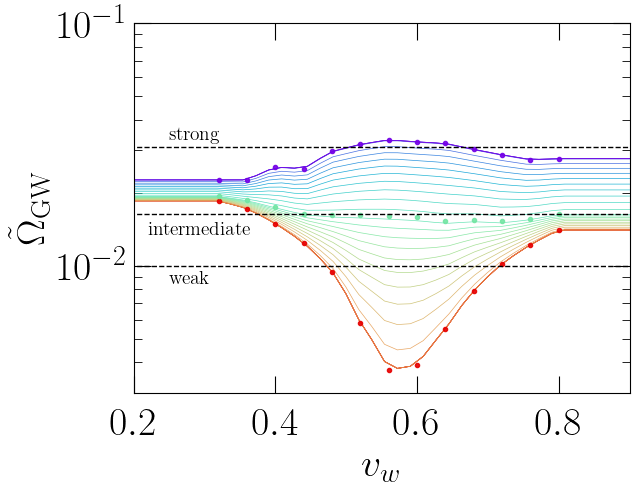

In [4]:
### The result of the interpolated values is shown here, where the black dashed lines
### indicate the amplitudes estimated in Caprini:2024gyk for weak (alpha = 0.0046),
### intermediate (alpha = 0.05) and strong (alpha = 0.5) phase transitions

# color maps
cols = cmap(np.linspace(0, 1, len(alphas)))
cols = tuple(component * darken_factor for component in cols)
cols2 = cmap(np.linspace(0, 1, len(val_alphas)))
cols2 = tuple(component * darken_factor for component in cols2)

for i in range(0, len(alphas)):     plt.plot(vws, OmGWtilde[:, i], color=cols[i], lw=.5)
for i in range(0, len(val_alphas)): plt.plot(val_vws, Omnums20[:, i], '.', color=cols2[i])

plt.xlabel(r'$v_w$')
plt.ylabel(r'$\tilde \Omega_{\rm GW}$')
plt.xlim(0.2, 0.9)
plt.ylim(3e-3, 1e-1)
plt.yscale('log')
plot_sets.axes_lines()

plt.hlines(1e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.25, 3.3e-2, 'strong', fontsize=14)
plt.hlines(1.64e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.22, 1.35e-2, 'intermediate', fontsize=14)
plt.hlines(3.1e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.25, 8.5e-3, 'weak', fontsize=14)

### The prefactor in the GW production is generalized in Caprini:2024gyk based on the locally stationary UETC, such that it can be expressed as

### $$ {\rm pref} = K^2_{\rm exp, int} \, (R_\ast H_\ast),$$ where $$K_{\rm exp, int}^2 = {\cal H}_\ast^{-1} \int_{\tau_\ast}^{\tau_{\rm fin}} \frac{K^2 (\tau)}{\tau^2} {\rm d}\,  \tau = K_0^2 \, \Upsilon_b (\delta \tau_{\rm fin})$$ and $\delta \tau_{\rm fin} = \tau_{\rm fin} - \tau_\ast$ is the sourcing duration in an expanding Universe.

### We will consider the duration to be given in terms of the shock formation time, $$\delta \tau_{\rm fin} = N_{\rm shock} R_\ast/\sqrt{v_{\rm f}^2}$$

### We then first compute the amount of kinetic energy at the end of the phase transition $K_0$. The first approach is to use the description of Espinosa:2010hh, $$K_\xi = \frac{\kappa \alpha}{1 + \alpha},$$ where $\kappa$ is the efficiency factor in the bag equation of state, which can be computed using *kappas_Esp* function in *hydro_bubbles.py*.

### The $v_f$ is the square of the enthalpy-weighted root-mean-square velocity, which we will denote as $\Omega_\xi$, $$\Omega_\xi = v_f^2 = \frac{\langle w \gamma^2 v^2\rangle}{\langle w \rangle} = \frac{\kappa \alpha}{1 + c_{\rm s}^2},$$ for an equation of state $p = c_{\rm s}^2 \rho$ where $c_{\rm s}^2 = 1/3$ is assumed to be a constant.

In [5]:
vws    = np.linspace(0.1, .99, 1000)
K_xi   = hb.kappas_Esp(vws, alphas)*alphas/(1 + alphas)
Oms_xi = hb.kappas_Esp(vws, alphas)*alphas/(1 + cs2)

### Alternatively, we can consider the value of $K(\tau)$ at the end of the phase transition $K_0 = K(\tau_0)$ obtained from the numerical simulations of Caprini:2024gyk.

### Similarly, Caprini:2024hue uses $K = 0.6 K_\xi$ based on the simulations of Jinno:2022mie. To incorporate a constant factor (like 0.6), the GW spectrum can just be multiplied by the squared of this factor, so this case does not require a particular option in the different functions of *CosmoGW*.

In [6]:
# take values from higgsless dataset
dirr = cGW.HOME + 'resources/higgsless/parameters_fit_sims.csv'
df   = pd.read_csv(dirr)

K0, K0num, _, _ = tmp.interpolate_HL_vals(df, vws, val_alphas, quiet=True, numerical=True,
                               value='curly_K_0_512', boxsize=20)

### We can compare the resulting $K_0$ from both methods. Both are available to compute the prefactor of the GW production using the function *OmGW_spec_sw* in *GW_templates.py* with the options *model_K0* = 'Espinosa' or 'higgsless'

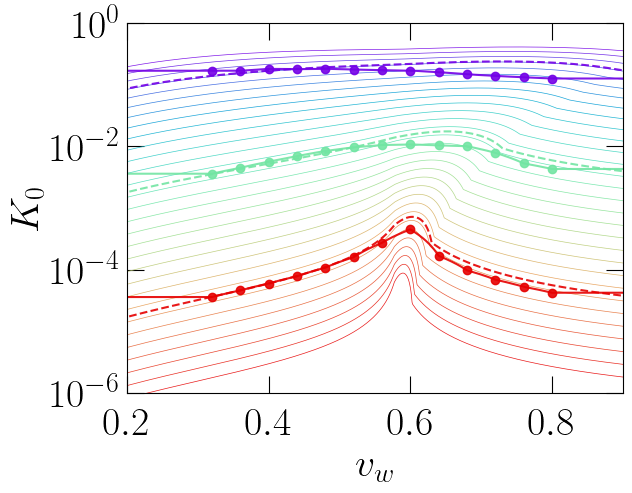

In [7]:
for i in range(0, len(alphas)):
    plt.plot(vws, K_xi[:, i], color=cols[i], lw=.5)

K_xi2 = hb.kappas_Esp(vws, val_alphas)*val_alphas/(1 + val_alphas)
for j in range(0, len(val_alphas)):
    plt.plot(vws, K0[:, j],    color=cols2[j])
    plt.plot(val_vws, K0num[:, j], 'o', color=cols2[j])
    plt.plot(vws, K_xi2[:, j], color=cols2[j], ls='dashed')
   
plt.yscale('log')
plt.ylabel(r'$K_0$')
plt.xlabel(r'$v_w$')
plt.xlim(0.2, 0.9)
plt.ylim(1e-6, 1e0)
plot_sets.axes_lines()

### We then compute the factor $K_{\rm exp, int}^2$ assuming a power-law in time $K(\tau) = K_0 (\tau/\tau_0)^{-b}$, where $b$ is estimated based on the numerical results of Caprini:2024gyk.

### When the decay is negligible ($b \simeq 0$), we recover the GW production from sound waves, which takes the following form when the expansion of the Universe can be neglected, $$K_{\rm int}^2 = K_\xi^2 \delta \tau_{\rm fin} {\cal H}_\ast,$$ and the following one taking into account the expansion in a radiation-dominated Universe, $$K_{\rm int, exp}^2 = K_\xi^2 \Upsilon(\delta \tau_{\rm fin}) = K_\xi^2 \frac{\delta \tau_{\rm fin} {\cal H}_\ast}{1 + \delta \tau_{\rm fin}{\cal H}_\ast},$$ which tends to one in the limit $\delta \tau_{\rm fin} {\cal H}_\ast \to \infty$, $$\lim_{\delta \tau_{\rm fin} {\cal H}_\ast \to \infty} K_{\rm int, exp}^2 = K_\xi^2.$$ This has justified some previous studies to consider $\min(\delta \tau_{\rm fin} {\cal H}_\ast, 1)$ as the source duration. However, this choice can lead to large relative errors and overestimates the amplitude of the GW spectrum.

### These results can be used calling the function *pref_GWB_sw* with *model* = 'sound_waves', or directly calling the function *OmGW_spec_sws* with the option *model_decay* = 'sound_waves'. To take into account expansion of the Universe, these functions should be called with the argument *expansion* = True

### Let us check the evolution with the source duration of the GW amplitude for different values of $\beta/H_\ast = (10, 100, 1000)$ and compare to the shock formation time for the chosen values of $\alpha = 0.0046, 0.05$ and $0.5$ when there is no decay of the source

Text(0.5, 0, '$\\delta \\tau_{\\rm fin} \\, \\beta$')

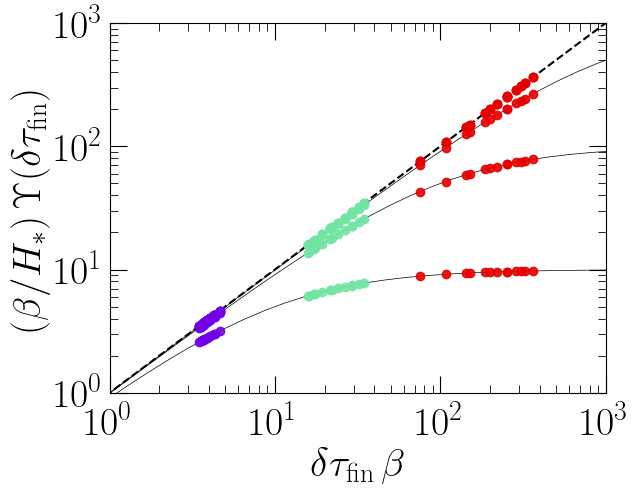

In [8]:
dtfins = np.logspace(-6, 6, 100)
plt.plot(dtfins, dtfins, color='black', ls='dashed')
Ups    = dtfins/(1 + dtfins)

betas = np.logspace(1, 3, 3)
Oms_xi2 = hb.kappas_Esp(val_vws, val_alphas)*val_alphas/(1 + cs2)
lf2   = hb.Rstar_beta(val_vws, corr=True)
lf2, _ = np.meshgrid(lf2, val_alphas, indexing='ij')
dtdur = lf2/np.sqrt(Oms_xi2)
for i in range(0, len(betas)):
    plt.plot(dtfins*betas[i], Ups*betas[i], color='black', lw=.5)
    for j in range(0, len(val_alphas)):
        plt.plot(dtdur[:, j], dtdur[:, j], 'o', color=cols2[j])
        plt.plot(dtdur[:, j], np.interp(dtdur[:, j]/betas[i], dtfins, Ups)*betas[i], 'o', color=cols2[j])

plt.loglog()
plt.xlim(1e0, 1e3)
plt.ylim(1e0, 1e3)
plot_sets.axes_lines()
plt.xticks(np.logspace(0, 3, 4))
plt.yticks(np.logspace(0, 3, 4))
plt.ylabel(r'$(\beta/H_\ast) \, \Upsilon (\delta \tau_{\rm fin})$')
plt.xlabel(r'$\delta \tau_{\rm fin} \, \beta$')

### Alternatively, we can take into account the decay of the source calling the function *pref_GWB_sw* with the option *model* = 'decaying' and providing the value of the decay exponent $b$, or directly calling the function *OmGW_spec_sws* with the option *model_decay* = 'decaying'.

### We can also use the values of $b$ interpolated from the numerical results of Caprini:2024gyk, where we note that for some of the phase transition parameters, especially for weak $\alpha$, the values of $b$ might deviate from the physical ones due to underresolution.

In [9]:
# take values from higgsless dataset
dirr = cGW.HOME + 'resources/higgsless/parameters_fit_sims.csv'
df   = pd.read_csv(dirr)

# take values from higgsless dataset
b, bnum, _, _ = tmp.interpolate_HL_vals(df, vws, alphas, quiet=True, numerical=True,
                                        value='b', boxsize=20)

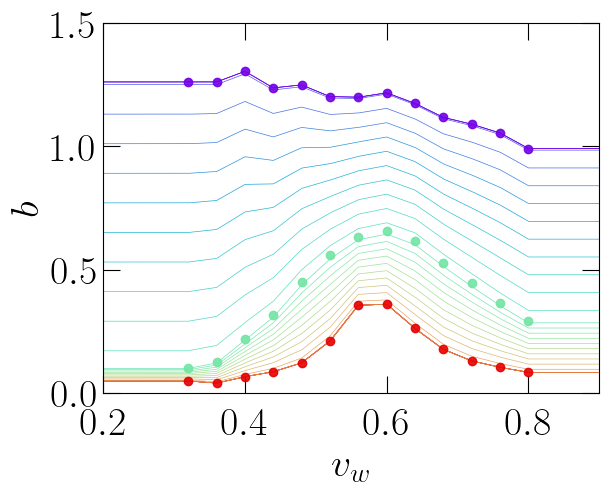

In [10]:
for i in range(0, len(alphas)):
    plt.plot(vws, b[:, i], color=cols[i], lw=.5)
for j in range(0, len(val_alphas)):
    plt.plot(val_vws, bnum[:, j], 'o', color=cols2[j])
   
plt.ylabel(r'$b$')
plt.xlabel(r'$v_w$')
plt.xlim(0.2, 0.9)
plt.ylim(0, 1.5)
plot_sets.axes_lines()

### Taking into account these values of $b$ for the decay, we can again reevaluate the evolution with the source duration of the GW amplitude and compare to the shock formation time for the chosen values of $\alpha = 0.0046, 0.05$ and $0.5$ including the effect from the decay.

### The resulting amplitude then becomes proportional to $$K_{\rm exp, int}^2 = K_0^2 \Upsilon_b (\delta \tau_{\rm fin}) \leq K_0^2 \Upsilon (\delta \tau_{\rm fin}).$$ Hence, the decay of the source will in general lead to smaller amplitudes of the GW spectrum for the same duration of the source. However, since this model applies after non-linearities develop, it allows to extend the duration to times longer than that of the shock formation time.

### For this purpose, let us first consider the dependence with the source duration without the Universe expansion, for which we have $$K_{\rm int}^2 = K_0^2 {\cal H}_\ast \tau_\ast^{2b} \int_{\tau_\ast}^{\tau_{\rm fin}} \tau^{-2b} {\rm d} \tau \leq K_0^2 \delta \tau_{\rm fin} {\cal H}_\ast$$ We can use the function *K2int* provided in the *GW_models.py* routine of *CosmoGW*. We show in dots the time of shock formation for each phase transition parameter point $(\alpha, v_w)$. Note that the simulations of Caprini:2024gyk only last until $\delta \tau_{\rm sim} \beta = 22$ so any results extrapolated beyond that might not be correct.

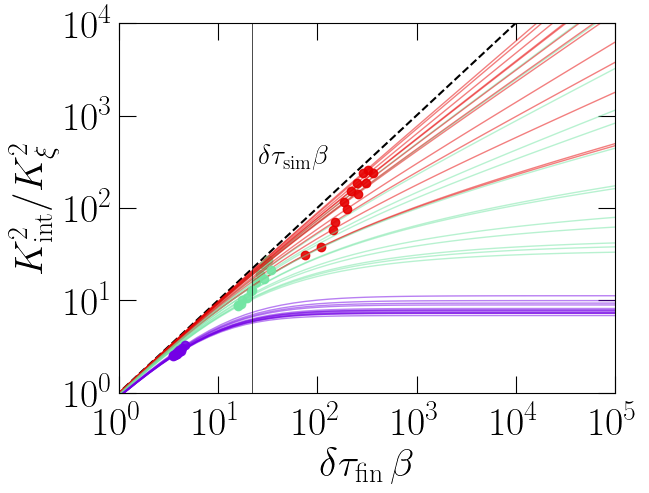

In [11]:
dtfins = np.logspace(-6, 6, 100)

plt.plot(dtfins, dtfins, color='black', ls='dashed')

K2int_flat = np.zeros((len(dtfins), len(val_vws), len(val_alphas)))
lf2   = hb.Rstar_beta(val_vws, corr=True)
lf2, _ = np.meshgrid(lf2, val_alphas, indexing='ij')
dtdur = lf2/np.sqrt(Oms_xi2)
K2int_flat_tdur = np.zeros((len(val_vws), len(val_alphas)))
for i in range(0, len(val_vws)):
    for j in range(0, len(val_alphas)):
        K2int_flat[:, i, j] = mod.K2int(dtfins, K0=1., b=bnum[i, j], expansion=False)
        plt.plot(dtfins,  K2int_flat[:, i, j], color=cols2[j], alpha=0.5, lw=1)

        K2int_flat_tdur[i, j]  = mod.K2int(dtdur[i, j], K0=1., b=bnum[i, j], expansion=False)
        plt.plot(dtdur[i, j], K2int_flat_tdur[i, j], 'o', color=cols2[j])

plt.xlim(1e0, 1e4)
plt.ylim(1e0, 1e4)
plt.loglog()

plt.xticks(np.logspace(0, 5, 6))
plt.yticks(np.logspace(0, 4, 5))
plt.vlines(22, 1e-1, 1e5, color='black', lw=0.5)
plt.text(26, 3e2, r'$\delta \tau_{\rm sim} \beta$')
plt.ylabel(r'$K^2_{\rm int}/K_\xi^2$')
plt.xlabel(r'$\delta \tau_{\rm fin} \, \beta$')
plot_sets.axes_lines()

### We can now include the effect of Universe expansion for different values of $\beta/H_\ast$

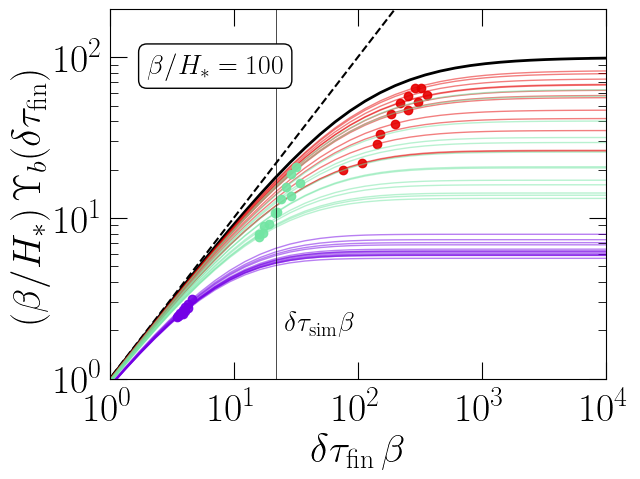

In [12]:
dtfins = np.logspace(-6, 6, 100)
betas  = np.logspace(1, 3, 3)

plt.plot(dtfins, dtfins, color='black', ls='dashed')

Ups    = dtfins/(1 + dtfins)
lf2    = hb.Rstar_beta(val_vws, corr=True)
lf2, _ = np.meshgrid(lf2, val_alphas, indexing='ij')
dtdur  = lf2/np.sqrt(Oms_xi2)

i = 1
plt.plot(dtfins*betas[i], Ups*betas[i], color='black', lw=2)
K2int_exp = np.zeros((len(dtfins), len(val_vws), len(val_alphas)))
K2int_exp_tdur = np.zeros((len(val_vws), len(val_alphas)))
for j in range(0, len(val_alphas)):
    for l in range(0, len(val_vws)):
        K2int_exp_tdur[l, j] = mod.K2int(dtdur[l, j]/betas[i], dt0=mod.dt0_ref, K0=1., b=bnum[l, j], expansion=True, beta=betas[i])
        plt.plot(dtdur[l, j], K2int_exp_tdur[l, j]*betas[i], 'o', color=cols2[j])
        K2int_exp[:, l, j] = mod.K2int(dtfins, K0=1., dt0=mod.dt0_ref, b=bnum[l, j], expansion=True, beta=betas[i])
        plt.plot(dtfins*betas[i], K2int_exp[:, l, j]*betas[i], color=cols2[j], alpha=0.5, lw=1)

plt.loglog()
plt.xlim(1e0, 1e4)
plt.ylim(1e0, 2e2)
plot_sets.axes_lines()
plt.xticks(np.logspace(0, 4, 5))
plt.yticks(np.logspace(0, 2, 3))
plt.vlines(22, 1e-1, 1e5, color='black', lw=0.5)
plt.text(26, 2e0, r'$\delta \tau_{\rm sim} \beta$')
plt.ylabel(r'$(\beta/H_\ast)\, \Upsilon_b (\delta \tau_{\rm fin})$')
plt.xlabel(r'$\delta \tau_{\rm fin} \, \beta$')
_ = plt.text(2, 8e1, r'$\beta/H_\ast = 100$', bbox=dict(boxstyle="round",fc='white'))

### Using the previous results, we have all the ingredients and choices to compute the prefactor $${\rm pref} = K_{\rm exp, int}^2 (R_\ast H_\ast)$$ that describes the GW amplitude, where the fluid length scale is related to the nucleation rate of the phase transition $\beta$, $$ R_\ast\beta = (8 \pi)^{1/3} \max(v_w, c_{\rm s})$$

In [13]:
### compute the GW prefactor as a function of an array of vws, alphas, betas

betas       = np.logspace(2, 3, 2)
pref_exp    = np.zeros((len(vws), len(alphas), len(betas)))
pref_exp2   = np.zeros((len(vws), len(alphas), len(betas)))
pref_sw_exp = np.zeros((len(vws), len(alphas), len(betas)))
for i in range(0, len(vws)):
    # ratio Rstar/beta using the correction max(vw, cs)
    lf = hb.Rstar_beta(vws[i], corr=True)/betas
    for j in range(0, len(alphas)):
        for l in range(0, len(betas)):
            pref_exp[i, j, l]    = tmp.pref_GWB_sw(Oms=Oms_xi[i, j], lf=lf[l], alpha=alphas[j], model='decay',
                                            Nshock=1, b=b[i, j], expansion=True, beta=betas[l], cs2=cs2)
            pref_exp2[i, j, l]   = tmp.pref_GWB_sw(Oms=Oms_xi[i, j], lf=lf[l], alpha=alphas[j], model='decay',
                                            Nshock=50, b=b[i, j], expansion=True, beta=betas[l], cs2=cs2)
            pref_sw_exp[i, j, l] = tmp.pref_GWB_sw(Oms=Oms_xi[i, j], lf=lf[l], alpha=alphas[j], model='sound_waves',
                                            Nshock=1., b=b[i, j], expansion=True, beta=betas[l], cs2=cs2)

### With these results, we can estimate what is the effect of the decay in the amplitude of the GW spectrum in an expanding background. On one hand, the simulations of Caprini:2024gyk evolve the system also beyond the time of shock formation (at least for large $\alpha$). Therefore, the amplitude will continue growing beyond the shock formation time following the non-linear dynamics. For how long we can extrapolate these results beyond the ending time of the simulations is an open problem as we expect non-linearities and turbulence to eventually overcome this production.

### In the first place, let's compare the amplitude at the time of shock formation. We can see that the inclusion of a decay always leads to a smaller amplitude of the GW spectrum. Below, we show the ratio of the $\Upsilon_b$ factor, taking into account the decay, to the $\Upsilon$ factor (with no decay). This ratio increases as $\beta/H_\ast$ increases, as the shock formation time is $\tau_{\rm sh} {\cal H}_\ast = (R_\ast \beta) (\beta/H_\ast)^{-1}/v_f$ and becomes smaller for larger $b$.

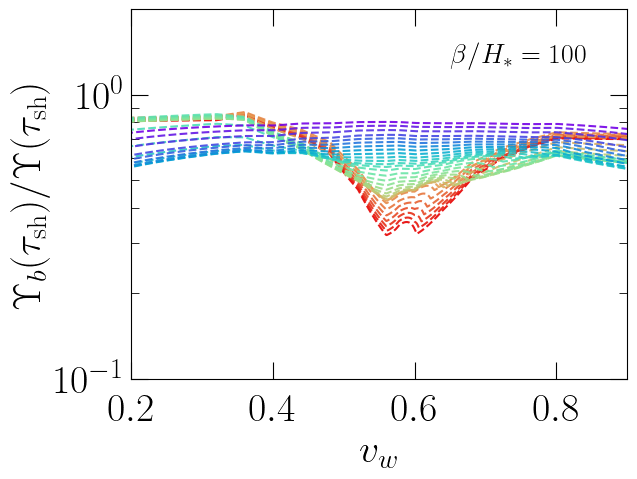

In [14]:
ind = 0
for i in range(0, len(alphas)):
    plt.plot(vws, pref_exp[:, i, ind]/pref_sw_exp[:, i, ind], color=cols[i], ls='dashed')
plt.yscale('log')
plt.ylabel(r'$\Upsilon_b (\tau_{\rm sh})/\Upsilon(\tau_{\rm sh})$')
plt.xlabel(r'$v_w$')
plt.text(0.65, 1.3, r'$\beta/H_\ast = 100$')
plt.xlim(0.2, 0.9)
plt.ylim(1e-1, 2)
plot_sets.axes_lines()

### However, as time evolves, the amplitude keeps growing, and the simulations of Caprini:2024gyk show that the development of non-linearities does not lead instantly to a saturation of the amplitude. Hence, if the GW amplitude continues to grow beyond this shock formation time, eventually its amplitude can become larger to the one estimated when decay of the source is ignored and the GW amplitude saturates at one shock formation time.

### Below we show the results for a duration of the sourcing 50 times that of the shock formation time, taking into account the decay of the kinetic energy. When the decay is strong, the growth is not as large, as the amplitude of the GW spectrum reaches saturation faster.

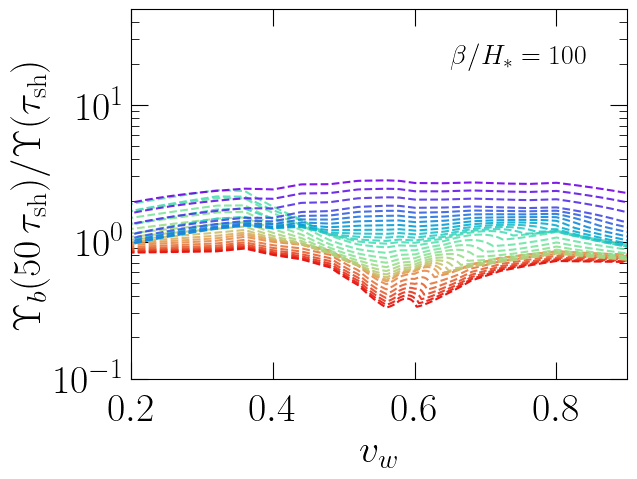

In [15]:
ind = 0
for i in range(0, len(alphas)):
    plt.plot(vws, pref_exp2[:, i, ind]/pref_sw_exp[:, i, ind], color=cols[i], ls='dashed')
plt.yscale('log')
plt.ylabel(r'$\Upsilon_b (50\, \tau_{\rm sh})/\Upsilon(\tau_{\rm sh})$')
plt.xlabel(r'$v_w$')
plt.text(0.65, 20, r'$\beta/H_\ast = 100$')
plt.xlim(0.2, 0.9)
plt.ylim(1e-1, 50)
plot_sets.axes_lines()

### Finally, we focus now on the spectral shape, for which we consider a few different options.

### *1.* The first option corresponds to the spectral shape used in Caprini:2019egz (used in PTplot), $$ S(s) = S_0 \, s^3 \biggl(\frac{7}{4 + 3 s^2}\biggr)^{7/2},$$ where $s = 2 \pi f {\cal R}_\ast/10$ and $S_0$ is a normalization constant such that $\int S(s) {\rm d}\ln s = 1$.

### This spectral shape can be considered calling the function *Sf_shape_sw* in the *GW_templates* module or the function *OmGW_spec_sw* using the argument *model_shape = sw_LISAold*

### *2.* The model including a second peak, based on the sound-shell model Hindmarsh:2019phv, can be used taking the following spectral shape, $$S(s) = S_0 \, s^9 \biggl(\frac{\Delta_w^4 + 1}{\Delta_w^4 + s^4}\biggr)^2 \biggl(\frac{5}{5 - m + ms^2}\biggr)^{5/2},$$ where $s = f {\cal R}_\ast \Delta_w$ with $\Delta_w = \frac{|v_w - c_{\rm s}|}{v_w}$ being the sound-shell thickness, which depends on the wall velocity, and $m = (9 \Delta_w^4)/(\Delta_w^4 + 1)$, such that $S/S_0 = 1$ at the peak $s = 1$.

### This model can be chosen taking the argument *model_shape = sw_SSM*.

### *3.* An update model based on the sound-shell model was proposed in RoperPol:2023bqa, where the low-frequency slope is corrected to $f^3$, instead of $f^9$, following the work of RoperPol:2023dzg and the Higgsless simulations of Jinno:2022mie, $$S(s) = 16 S_0 \, s^3 \biggl(\frac{\Delta_w^3 + 1}{\Delta_w^3 + s^3}\biggr)^{2/3} (3 + s^2)^{-2},$$ defined such that $S/S_0 = 1$ at $s = 1$ and, again, $s = {\cal R}_\ast f \Delta_w$.

### This model can be chosen taking the argument *model_shape = sw_HL*.

### Before going over the more recent templates, let us first compare the spectral shape based on these different models

Text(0, 0.5, '$S (f {\\cal R}_\\ast)$')

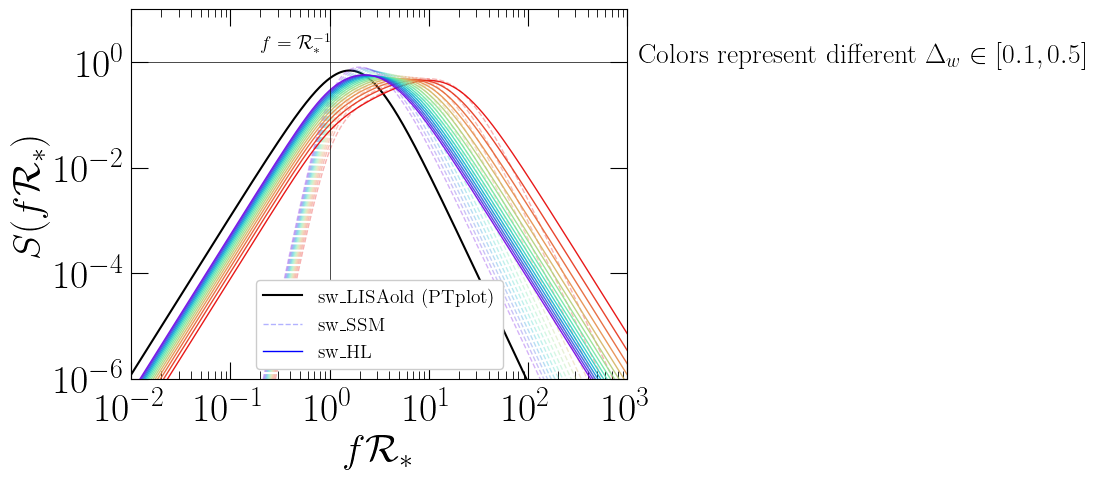

In [16]:
s = np.logspace(-3, 5, 1000)

# sw_LISAold model
S  = tmp.Sf_shape_sw(s, model='sw_LISAold')
S0 = 1./np.trapezoid(S, np.log(s))
S_swLISAold  = S*S0
plt.loglog(s, S_swLISAold, color='black', label='sw_LISAold (PTplot)')

# the result changes for different sound shell thickness
Dw = np.linspace(0.1, 0.5, 15)
cols3  = cmap(np.linspace(0, 1, len(Dw)))
cols3  = tuple(component * darken_factor for component in cols3)

# sw_SSM model
S  = tmp.Sf_shape_sw(s, Dw=Dw, model='sw_SSM')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_swSSM  = S*S0
for i in range(0, len(Dw)):
    plt.loglog(s, S_swSSM[:, i], ls='dashed', color=cols3[i], lw=1, alpha=.3)
plt.plot([], [], color='blue', ls='dashed', lw=1, label='sw_SSM', alpha=.3)

# sw_HL model
S  = tmp.Sf_shape_sw(s, Dw=Dw, model='sw_HL')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_swHL = S*S0
for i in range(0, len(Dw)):
    plt.loglog(s, S_swHL[:, i], color=cols3[i], lw=1)
plt.plot([], [], color='blue', lw=1, label='sw_HL')

plt.legend(fontsize=14, framealpha=True)
plt.xlim(1e-2, 1e3)
plt.ylim(1e-6, 1e1)
plt.yticks(np.logspace(-6, 0, 4))
plt.hlines(1, 1e-2, 1e4, color='black', lw=.5)
plt.vlines(1, 1e-9, 1e4, color='black', lw=.5)
plot_sets.axes_lines()
plt.text(1.3e3, 1e0, r'Colors represent different $\Delta_w \in [0.1, 0.5]$')
plt.text(.2, 1.8, r'$f = {\cal R}_\ast^{-1}$', fontsize=14)
plt.xlabel(r'$f {\cal R}_\ast$')
plt.ylabel(r'$S (f {\cal R}_\ast)$')

### Let us now consider the recent template used by the LISA Cosmology working group (Caprini:2024hue) and the one developed in Caprini:2024gyk.

### *3.* The LISA CosWG paper considered the following generic doubly broken power law, based on the results of Higgsless simulations in Jinno:2022mie, and preliminary results later presented in Caprini:2024hue, $$S(s) = S_0 \, \biggl(\frac{f}{f_1} \biggr)^a \biggl[1 + \biggl(\frac{f}{f_1}\biggr)^{\alpha_1} \biggr]^{(a - b)/\alpha_1} \biggl[1 + \biggl(\frac{f}{f_2}\biggr)^\alpha_2 \biggr]^{-(b + c)/\alpha_2},$$ where $S_0$ is a normalization constant such that $\int S(f) \, {\rm d} \ln f = 1$. This type of spectrum are available using the function *smoothed_double_bPL* in *GW_analytical* using the argument *alpha2 = True* (default is a slightly different convention used in other work).

### In Caprini:2024hue, the following values are considered: slopes $a_1 = 3$, $a_2 = 1$, $a_3 = 3$ as in previous work, and smoothness parameters $\alpha_1 = 2$ and $\alpha_2 = 4$. The positions of the frequencies are such that $f/f_1 = 5f {\cal R}_\ast$ and $f/f_2 = 2 f {\cal R}_\ast \Delta_w$. However, the sound-shell thickness is in this case computed using $\Delta_w = \xi_{\rm shell}/\max(v_w, c_{\rm s})$.

### This template is available in *CosmoGW* using the option *model_shape = sw_LISA*

### Note that previous templates (sw_SSM and sw_HL) can also be expressed in this generic form (available in *smoothed_double_bPL*) using $a = 9$, $b = 1$, $c = 4$, $\alpha_1 = 4$, $\alpha_2 = 2$, $f/f_1 = f {\cal R}_\ast$, and $f/f_2 = \sqrt{m/(5 -m)} f {\cal R}_\ast \Delta_w$ (sw_SSM) and $a = 3$, $b = 1$, $c = 3$, $\alpha_1 = 1.5$, $\alpha_2 = 0.5$, $f/f_1 = f {\cal R}_\ast$, and $f/f_2 = c_{\rm s} f {\cal R}_\ast \Delta_w$.

### *4.* Caprini:2024gyk presents the same fit for a doubly broken power law and uses the results of the Higgsless numerical simulations to compute the spectral parameters. The simulations are ran for $\alpha = 0.0046$, $\alpha = 0.05$, and $\alpha = 0.5$, and finds, after averaging over statistical realizations and wall velocities, the parameters $\alpha_1 = 3.6$, $\alpha_2 = 2.4$, $f/f_1 = 2.5 f {\cal R}_\ast$, and $f/f_2 = 2 f {\cal R}_\ast \Delta_w$ for weak phase transitions (0.0046), while no dependence on $\Delta_w$ is found for intermediate (0.05) and strong (0.5) phase transitions, $f/f_2 = f {\cal R}_\ast$ and $f/f_2 = 2 f {\cal R}_\ast$, respectively.

### This template is available in *CosmoGW* using the option *model_shape = sw_HLnew* with the argument *strength = 'weak', 'interm', or 'strong'*

### Both templates consider the dependence on the actual sound-shell thickness $\Delta_w = \xi_{\rm shell}/\max(v_w, c_s)$, which depends on both the wall velocity and the strength of the phase transition. It can be computed using the *hydro_bubbles* module in *CosmoGW*. Below we show the spectral shape for a few cases.

Text(0, 0.5, '$S (f {\\cal R}_\\ast)$')

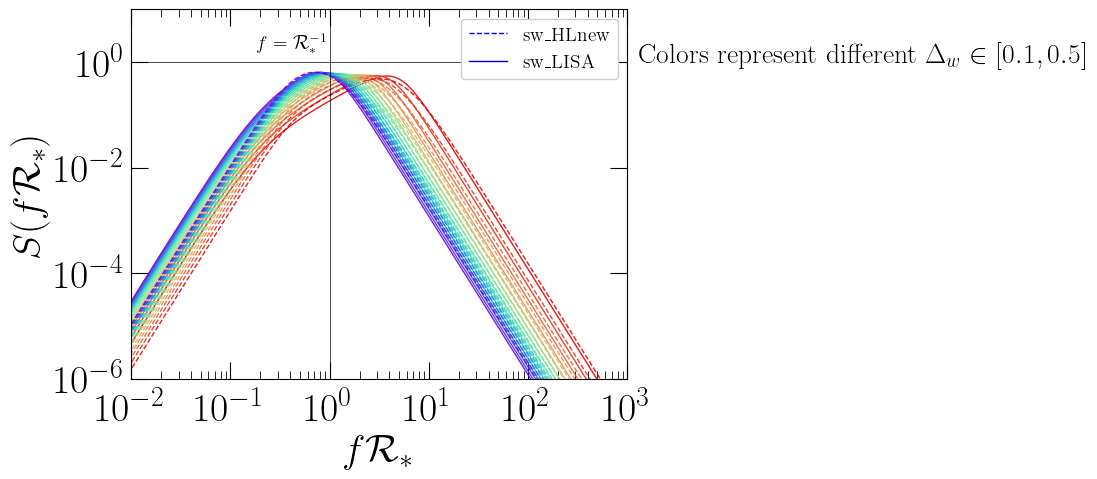

In [17]:
# spectral shape using model sw_LISA
S  = tmp.Sf_shape_sw(s, Dw=Dw, model='sw_LISA')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_sw_LISA = S*S0
for i in range(0, len(Dw)):
    plt.loglog(s, S_sw_LISA[:, i], color=cols3[i], lw=1)

# spectral shape using model sw_HLnew
S = tmp.Sf_shape_sw(s, Dw=Dw, model='sw_HLnew')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_sw_HL = S*S0
for i in range(0, len(Dw)):
    plt.loglog(s, S_sw_HL[:, i], ls='dashed', color=cols3[i], lw=1)

plt.plot([], [], color='blue', ls='dashed', lw=1, label='sw_HLnew')
plt.plot([], [], color='blue', lw=1, label='sw_LISA')

plt.legend(fontsize=14, framealpha=True)
plt.xlim(1e-2, 1e3)
plt.ylim(1e-6, 1e1)
plt.yticks(np.logspace(-6, 0, 4))
plt.hlines(1, 1e-2, 1e4, color='black', lw=.5)
plt.vlines(1, 1e-9, 1e4, color='black', lw=.5)
plot_sets.axes_lines()
plt.text(1.3e3, 1e0, r'Colors represent different $\Delta_w \in [0.1, 0.5]$')
plt.text(.18, 1.8, r'$f = {\cal R}_\ast^{-1}$', fontsize=14)
plt.xlabel(r'$f {\cal R}_\ast$')
plt.ylabel(r'$S (f {\cal R}_\ast)$')

### We can observe how the resulting spectral shape are rather compatible and the recent results from the simulations of Caprini:2024gyk justify the validity of the analysis in Caprini:2024hue. However, for intermediate and strong phase transitions, a second peak does not seem to depend any longer on $\Delta_w$ in the Higgsless simulations and the ratio between $f_1$ and $f_2$ becomes constant, $f_2/f_1 = 2.5$ for strong phase transitions and $f_2/f_1 = 1.25$ for intermediate ones. These can be used calling the spectral shape function in *CosmoGW* using the arguments *model_shape='sw_HLnew'* and *strength='interm' or 'strong'*

Text(0, 0.5, '$S (f {\\cal R}_\\ast)$')

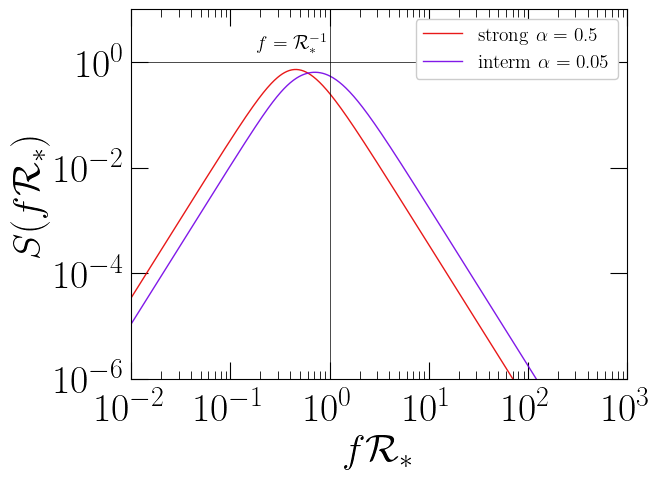

In [18]:
# spectral shape using model sw_HLnew
S  = tmp.Sf_shape_sw(s, model='sw_HLnew', strength='strong')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_sw_HLstr = S*S0
plt.loglog(s, S_sw_HLstr, color=cols3[0], lw=1, label=r'strong $\alpha = 0.5$')

S     = tmp.Sf_shape_sw(s, model='sw_HLnew', strength='interm')
S0 = 1./np.trapezoid(S, np.log(s), axis=0)
S_sw_HLint = S*S0
plt.loglog(s, S_sw_HLint, color=cols3[-1], lw=1, label=r'interm $\alpha = 0.05$')

plt.legend(fontsize=14, framealpha=True)
plt.xlim(1e-2, 1e3)
plt.ylim(1e-6, 1e1)
plt.yticks(np.logspace(-6, 0, 4))
plt.hlines(1, 1e-2, 1e4, color='black', lw=.5)
plt.vlines(1, 1e-9, 1e4, color='black', lw=.5)
plot_sets.axes_lines()
plt.text(.18, 1.8, r'$f = {\cal R}_\ast^{-1}$', fontsize=14)
plt.xlabel(r'$f {\cal R}_\ast$')
plt.ylabel(r'$S (f {\cal R}_\ast)$')

### One last option is available in *CosmoGW*, which corresponds to using the values of the spectral peak positions $k_1$ and $k_2$ interpolating the results from the Higgsless simulations of Caprini:2024gyk. Note that the position of the knee $k_1$ is close to the IR wave number of the simulations and hence, its extraction is difficult. Similarly, for weak phase transitions, the value of $k_2$ for confined hybrids (small sound-shell thickness) becomes unresolved in the UV for some cases. The interpolated values can be taken using the argument *interpolate_HL = True* when calling the spectral shape with *model_shape = sw_HL_new*.

### Let us have a look at the numerical results and their interpolated values, starting with $k_1$, and compared to the averaged value found $f_1 {\cal R}_\ast = 0.39$

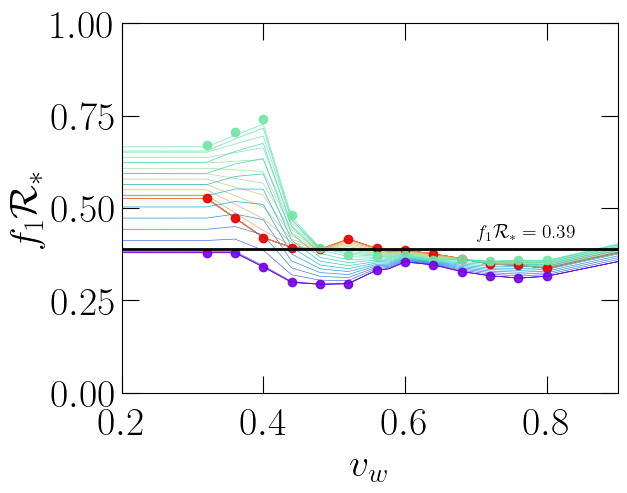

In [19]:
# take values from higgsless dataset
k1, k1num, _, _ = tmp.interpolate_HL_vals(df, vws, alphas, quiet=True, numerical=True,
                                          value='k1', boxsize=40)

# note that k1 are normalized with beta in the simulation results
for i in range(0, len(alphas)):
    plt.plot(vws, k1[:, i]*hb.Rstar_beta(vws=vws, corr=True)/2/np.pi, color=cols[i], lw=.5)
for j in range(0, len(val_alphas)):
    plt.plot(val_vws, k1num[:, j]*hb.Rstar_beta(vws=val_vws, corr=True)/2/np.pi, 'o', color=cols2[j])

plt.hlines(.39, 0.1, 1, color='black', lw=2)
plt.ylabel(r'$f_1 {\cal R}_\ast$')
plt.text(0.7, 0.42, r'$f_1 {\cal R}_\ast = 0.39$', fontsize=14)
plt.xlabel(r'$v_w$')
plt.xlim(0.2, 0.9)
plt.ylim(0, 1)
plot_sets.axes_lines()

### The position of the second spectral peak $k_2$ is now shown, comparing the numerical values found in Caprini:2024gyk, their averaged values used in the template shown above *sw_HLnew*, and the interpolated results for different values of $\alpha$.

### We first compute $\Delta_w$ for $\alpha = 0.0046$ to compare with the numerical results

In [20]:
vwss = np.linspace(0.1, 0.99, 20)
_, _, _, _, _, _, xi_shocks,_ = \
           hb.compute_profiles_vws_multalp(val_alphas, vws=vwss)
Dw = np.zeros((len(vwss), len(val_alphas)))
for i in range(0, len(val_alphas)):
    Dw[:, i] = (xi_shocks[:, i] - np.minimum(vwss, cs))/np.maximum(vwss, cs)

Text(0, 0.5, '$f_2 {\\cal R}_\\ast$')

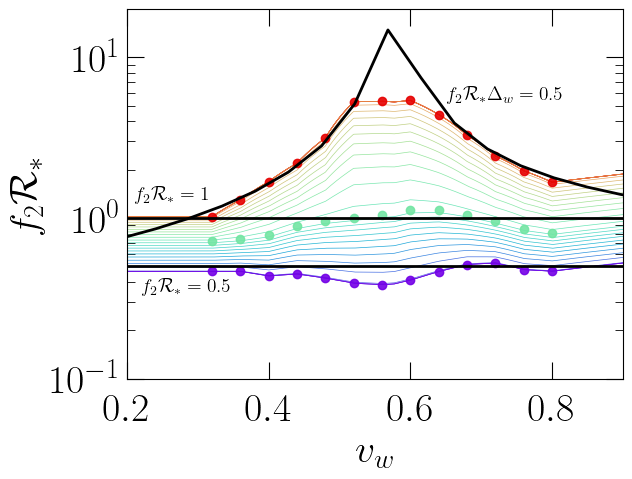

In [21]:
# take values from higgsless dataset
k2, k2num, _, _ = tmp.interpolate_HL_vals(df, vws, alphas, quiet=True, numerical=True,
                                          value='k2', boxsize=20)

# note that k2 are normalized with beta in the simulation results
for i in range(0, len(alphas)):
    plt.plot(vws, k2[:, i]*hb.Rstar_beta(vws=vws, corr=True)/2/np.pi, color=cols[i], lw=.5)
for j in range(0, len(val_alphas)):
    plt.plot(val_vws, k2num[:, j]*hb.Rstar_beta(vws=val_vws, corr=True)/2/np.pi, 'o', color=cols2[j])

plt.plot(vwss, .5/Dw[:, 0], lw=2, color='black')
plt.hlines(.5, 0.1, 1, lw=2, color='black')
plt.hlines(1, 0.1, 1, lw=2, color='black')
plt.xlim(0.2, 0.9)
plt.ylim(1e-1, 2e1)
plot_sets.axes_lines()
plt.text(0.65, 5.5, r'$f_2 {\cal R}_\ast \Delta_w = 0.5$', fontsize=14)
plt.text(0.21, 1.3, r'$f_2 {\cal R}_\ast = 1$', fontsize=14)
plt.text(0.22, .35, r'$f_2 {\cal R}_\ast = 0.5$', fontsize=14)
plt.yscale('log')
plt.xlabel(r'$v_w$')
plt.ylabel(r'$f_2 {\cal R}_\ast$')

### One additional result found in Caprini:2024gyk is that for some intermediate and strong phase transitions vortical motion starts to develop. Therefore, the spectral slope at large frequencies can deviate with respect to the one from purely compressional turbulence (-3) and become shallower (as the one found in Kolmogorov turbulence, -8/3). Indeed, in some cases a shallower value of $n_3$ is directly found in the GW spectrum. The current data from the simulations can also be interpolated. However, take these results with a grain of salt as they require further studies of the kinetic spectrum.

### To use these values of $n_3$ one can call the spectral shape function with *interpolate_HL = True* and *interpolate_HL_n3 = True*

In [22]:
# take values from higgsless dataset
n3, n3num, _, _ = tmp.interpolate_HL_vals(df, vws, alphas, quiet=True, numerical=True,
                                          value='n3', boxsize=20)

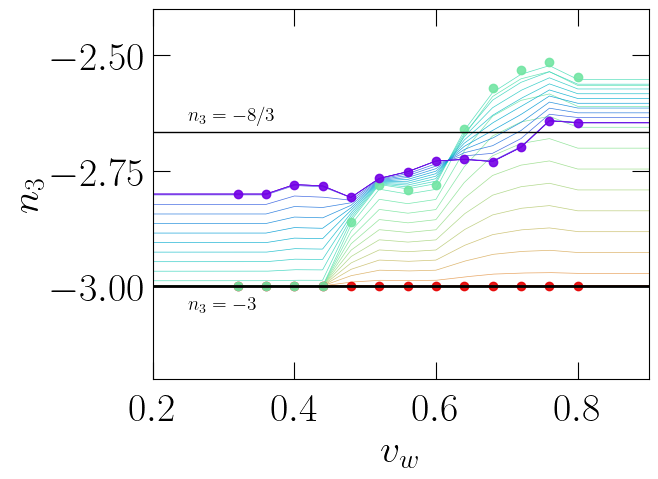

In [23]:
for i in range(0, len(alphas)):
    plt.plot(vws, n3[:, i], color=cols[i], lw=.5)
for j in range(0, len(val_alphas)):
    plt.plot(val_vws, n3num[:, j], 'o', color=cols2[j])

plt.hlines(-3, 0.1, 1, lw=2, color='black')
plt.xlabel(r'$v_w$')
plt.ylabel(r'$n_3$')
plt.hlines(-8/3, .1, 1, lw=1, color='black')
plt.text(0.25, -2.64, r'$n_3 = -8/3$', fontsize=14)
plt.text(0.25, -3.05, r'$n_3 = -3$', fontsize=14)
plt.ylim(-3.2, -2.4)
plt.xlim(0.2, 0.9)
plot_sets.axes_lines()

### We can now compare the spectral shape found from interpolating the spectral parameters with those using the averaged ones (see plots below)

In [24]:
%%time

_, _, _, _, _, _, xi_shocks,_ = \
           hb.compute_profiles_vws_multalp(val_alphas, vws=val_vws)
Dw = np.zeros((len(val_vws), len(val_alphas)))
for i in range(0, len(val_alphas)):
    Dw[:, i] = (xi_shocks[:, i] - np.minimum(val_vws, cs))/np.maximum(val_vws, cs)

cols4  = cmap(np.linspace(0, 1, len(val_vws)))
cols4  = tuple(component * darken_factor for component in cols4)

CPU times: user 7.22 s, sys: 30.5 ms, total: 7.25 s
Wall time: 7.26 s


You are using values that are interpolated from numerical data with L/vw =  40 and 20
Take into account that only alpha = 0.0046, 0.05  and 0.5 are found in simulations for vws from 0.32 to 0.8
Values out of this range should be taken with care


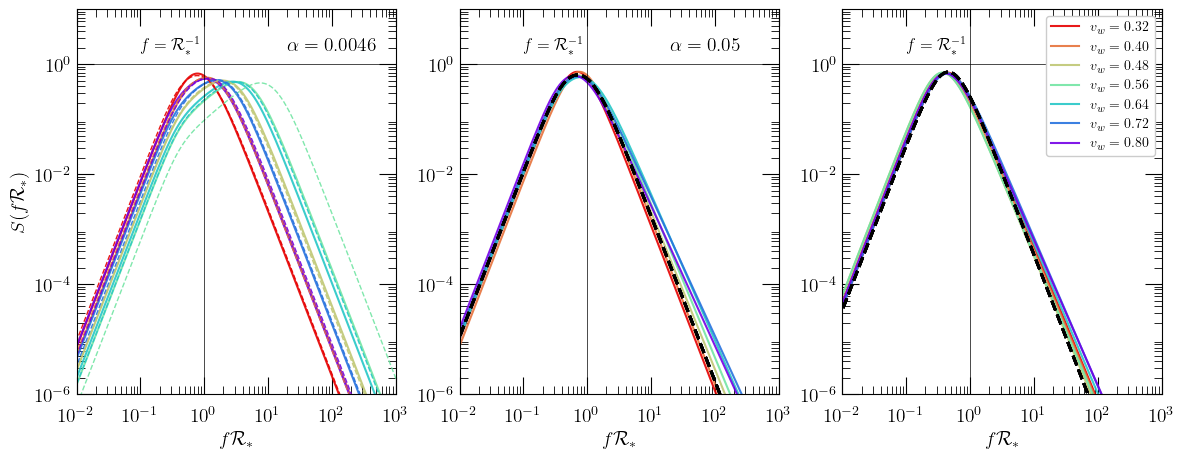

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(14,5))

S = tmp.Sf_shape_sw(s, model='sw_HLnew', vws=val_vws, alphas=val_alphas, interpolate_HL=True, interpolate_HL_n3=True)
S0 = 1./np.trapezoid(S, np.log(s), axis=0)

for j in range(0, len(val_alphas)):
    for i in range(0, len(val_vws)):
        if i%2 == 0:
            axs[j].loglog(s, S[:, i, j]*S0[i, j], color=cols4[i], label=r'$v_w = %.2f$'%val_vws[i])
            axs[j].tick_params(axis='x', labelsize=14)
            axs[j].tick_params(axis='y', labelsize=14)

# spectral shape using model sw_HLnew
strs    = ['weak', 'interm', 'strong']
str_alp = ['0.0046', '0.05', '0.5']

for j in range(0, len(strs)):
    S  = tmp.Sf_shape_sw(s, Dw=Dw, model='sw_HLnew', strength=strs[j])
    S0 = 1./np.trapezoid(S, np.log(s), axis=0)
    for i in range(0, len(val_vws)):
        if i%2 == 0:
            if j == 0:
                axs[j].loglog(s, S[:, i, j]*S0[i, j], ls='dashed', color=cols4[i], lw=1)
            else:
                axs[j].loglog(s, S*S0, ls='dashed', color='black', lw=2)

    if j == 2: axs[j].legend(fontsize=10, framealpha=True)
    if j == 0: axs[j].set_ylabel(r'$S (f {\cal R}_\ast)$', fontsize=14)
    axs[j].set_xlim(1e-2, 1e3)
    axs[j].set_ylim(1e-6, 1e1)
    axs[j].set_yticks(np.logspace(-6, 0, 4))
    axs[j].hlines(1, 1e-2, 1e4, color='black', lw=.5)
    axs[j].vlines(1, 1e-9, 1e4, color='black', lw=.5)
    plot_sets.axes_lines(ax=axs[j])
    axs[j].text(.1, 1.8, r'$f = {\cal R}_\ast^{-1}$', fontsize=12)
    axs[j].set_xlabel(r'$f {\cal R}_\ast$', fontsize=14)
    axs[j].text(2e1, 1.8, r'$\alpha = %s$'%str_alp[j], fontsize=14)

#### We can use the function *OmGW_spec_sw* of the module *GW_templates* in *CosmoGW* to generate the GW spectrum using different available templates and models in the literature. We describe each of them below.

#### We will use the numerical results of Caprini:2024gyk to compute the GW spectrum and will interpolate the parameters for each phase transition. We will compare the resulting spectral shape for a range of wall velocities $v_w \in [0.32, 0.8]$, $\alpha \in [0.0046, 0.5]$ and $\beta/H_\ast \in [12, 1000]$ with those obtained from the templates used in the analysis of the LISA CosWG (see Caprini:2024hue).

In [26]:
# range of frequencies normalized with the fluid length scale s = fR*
s = np.logspace(-3, 3, 1000)

alphas = np.logspace(np.log10(4.6e-3), np.log10(0.5),  30)
vws    = np.array([0.36, 0.6, .76])
betas  = [12, 100, 1000, 1e6]

_, _, val_alphas, val_vws  = tmp.ampl_GWB_sw(model='higgsless', vws=vws,
                                             alphas=alphas, numerical=True, quiet=True,
                                             bs_HL=20)

In [27]:
# temperature scale and relativistic degrees of freedom of the phase transition
T = 100*u.GeV
g = 100

# GW spectrum obtained considering sound waves, taking a fixed amplitude OmGWtilde = 1e-2,
# taking the kinetic energy fraction from the single bubble results of Espinosa:2010hh, and the
# spectral shape of Caprini:2024hue (sw_LISA)

# In all cases, we consider an expanding Universe with the sourcing process taking place during
# the radiation-dominated era

freq, OmGW = tmp.OmGW_spec_sw(s, alphas, betas, vws=vws, expansion=True, Nsh=1.,
              model_efficiency='fixed_value', model_K0='Espinosa',
              model_decay='sound_waves', model_shape='sw_LISA', redshift=True, T=T, gstar=g)

freq2, OmGW2 = tmp.OmGW_spec_sw(s, val_alphas, betas, vws=vws, expansion=True, Nsh=1.,
              model_efficiency='fixed_value', model_K0='Espinosa',
              model_decay='sound_waves', model_shape='sw_LISA', redshift=True, T=T, gstar=g)


# GW spectrum obtained considering decaying compressional motion, taking the amplitude OmGWtilde, the
# kinetic energy fraction, and the spectral shape (sw_HLnew) parameters interpolated from the simulation results
# of Caprini:2024gyk. As the model continues after the shock formation time, we allow the time of sourcing to
# be larger than one shock formation time (Nsh = 100).

freq3, OmGW3 = tmp.OmGW_spec_sw(s, alphas, betas, vws=vws, expansion=True, Nsh=100,
                 model_efficiency='higgsless', model_K0='higgsless',
                 model_decay='decay', interpolate_HL_decay=True, model_shape='sw_HLnew', interpolate_HL_shape=True,
                 interpolate_HL_n3=True, redshift=True, T=T, gstar=g)

freq4, OmGW4 = tmp.OmGW_spec_sw(s, val_alphas, betas, vws=vws, expansion=True, Nsh=100,
                 model_efficiency='higgsless', model_K0='higgsless',
                 model_decay='decay', interpolate_HL_decay=True, model_shape='sw_HLnew', interpolate_HL_shape=True,
                 interpolate_HL_n3=True, redshift=True, T=T, gstar=g)

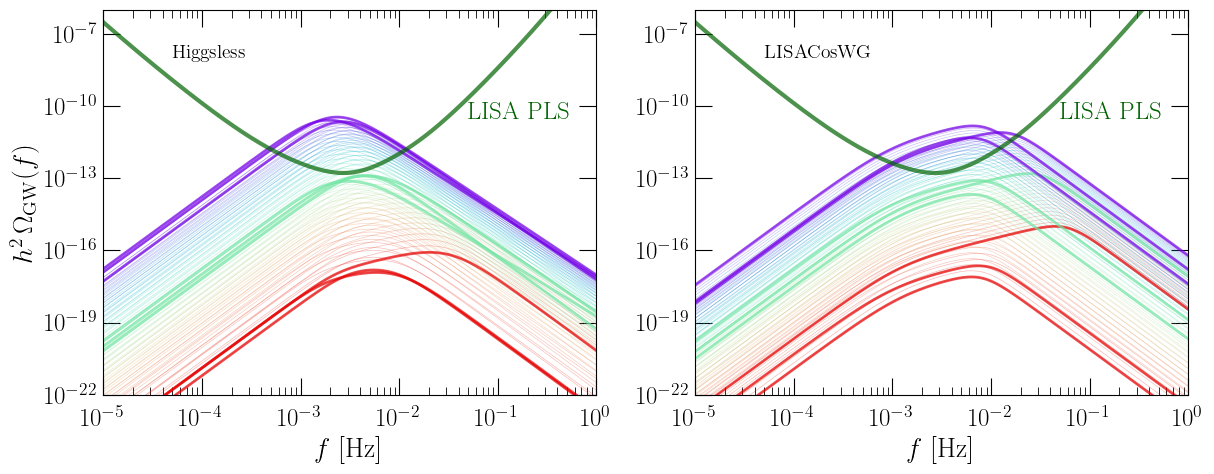

In [28]:
cols2 = cmap(np.linspace(0, 1, len(alphas)))
cols2 = tuple(component * darken_factor for component in cols2)

cols = cmap(np.linspace(0, 1, len(val_alphas)))
cols = tuple(component * darken_factor for component in cols)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

for i in range(1, 2):
    if i == 0: ls='solid'
    if i == 1: ls='solid'
    if i == 2: ls='dotted'
    for j in range(0, len(alphas)):
        for l in range(0, len(vws)):
            axs[1].loglog(freq[:, l, i]*2*np.pi, OmGW[:, l, j, i], color=cols2[j], ls=ls, lw=.5, alpha=0.3)
            axs[0].loglog(freq3[:, l, i]*2*np.pi, OmGW3[:, l, j, i], color=cols2[j], ls=ls, lw=.5, alpha=0.3)

    for j in range(0, len(val_alphas)):
        for l in range(0, len(vws)):
            axs[1].loglog(freq2[:, l, i]*2*np.pi, OmGW2[:, l, j, i], color=cols[j], ls=ls, lw=2, alpha=0.7)
            axs[0].loglog(freq4[:, l, i]*2*np.pi, OmGW4[:, l, j, i], color=cols[j], ls=ls, lw=2, alpha=0.7)

f_LISA, _, LISA_OmPLS = inte.read_sens(SNR=10, T=4)

for j in [0, 1]:
    axs[j].plot(f_LISA, LISA_OmPLS, lw=3, alpha=.7, color='darkgreen')
    axs[j].set_xlim(1e-5, 1e0)
    axs[j].set_ylim(1e-22, 1e-6)
    axs[j].set_xlabel(r'$f$ [Hz]', fontsize=20)
    axs[j].tick_params(axis='x', labelsize=18)
    axs[j].tick_params(axis='y', labelsize=18)
    plot_sets.axes_lines(ax=axs[j])
    axs[j].text(5e-2, 3e-11, r'LISA PLS', color='darkgreen', fontsize=18)
axs[0].set_ylabel(r'$h^2 \, \Omega_{\rm GW} (f)$', fontsize=20)
axs[1].text(5e-5, 1e-8, r'LISACosWG', fontsize=14)
axs[0].text(5e-5, 1e-8, r'Higgsless', fontsize=14)

try: plt.savefig('plots/GW_template_HL_vs_CosWG.pdf', bbox_inches='tight')
except: print('plot not saved! create directory plots to save figure')